IMPORTS

In [385]:
import pandas as pd
import sklearn
import scipy
import sklearn.ensemble as forest
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import sklearn.gaussian_process as kriging
import seaborn as sns
from tensorflow import keras
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.preprocessing import *
from feature_engine import wrappers
from sklearn.compose import ColumnTransformer

Tratamento Dos Dados

In [333]:
dfx=pd.DataFrame(pd.read_csv(filepath_or_buffer='DadosMetamodelagemX1.csv',delimiter=',',index_col=False,names=['ReactionTemperature','H2FlowRate','SplitsValues','RefluxRatio','ReactorVolume','FeedPressure','NANx']))
dfy=pd.DataFrame(pd.read_csv('DadosMetamodelagemY1.csv',names=['ISBL','CustoMateriaPrima','CustoUtilidades','Methanol','IsValid','IsConverged','StreamConvergeance','NANy']))
dft=pd.DataFrame.join(dfx,dfy)
dft.drop(dft.loc[dft['StreamConvergeance']==False].index,inplace=True)
dft.drop(columns=['NANx','NANy','IsValid','StreamConvergeance','IsConverged'],inplace=True)
dft.reset_index(inplace=True,drop=True)
target=['TotalCost','Methanol','CustoMateriaPrima']
features=['ReactionTemperature','H2FlowRate','SplitsValues','RefluxRatio','ReactorVolume','FeedPressure']
dfy

,ISBL,CustoMateriaPrima,CustoUtilidades,Methanol,IsValid,IsConverged,StreamConvergeance,NANy
0,6.324012e+07,8429.803789,8.402719e+05,1489.451640,True,True,True,NaN
1,6.185752e+07,8435.050635,7.654569e+05,2011.988123,True,True,True,NaN
2,6.146508e+07,8428.181993,7.146938e+05,1466.539121,True,True,True,NaN
3,6.037917e+07,8430.003873,7.020421e+05,1632.057518,True,True,True,NaN
4,6.217460e+07,8431.804072,7.173582e+05,1800.014412,True,True,True,NaN
...,...,...,...,...,...,...,...,...
619,7.206682e+07,8435.645922,1.228082e+06,1875.979405,True,True,True,NaN
620,5.560537e+07,8430.596927,5.588165e+05,1636.619088,True,True,True,NaN
621,5.627673e+07,8429.760276,5.698795e+05,1590.270837,True,True,True,NaN
622,5.584242e+07,8433.630875,5.916824e+05,1903.634528,True,True,True,NaN


In [336]:
TotalCost=pd.DataFrame({'TotalCost':(dft['ISBL']+dft['CustoUtilidades']+dft['CustoMateriaPrima'])})
dft=dft.join(TotalCost)

HeatMap Das Correlações

<Axes: >

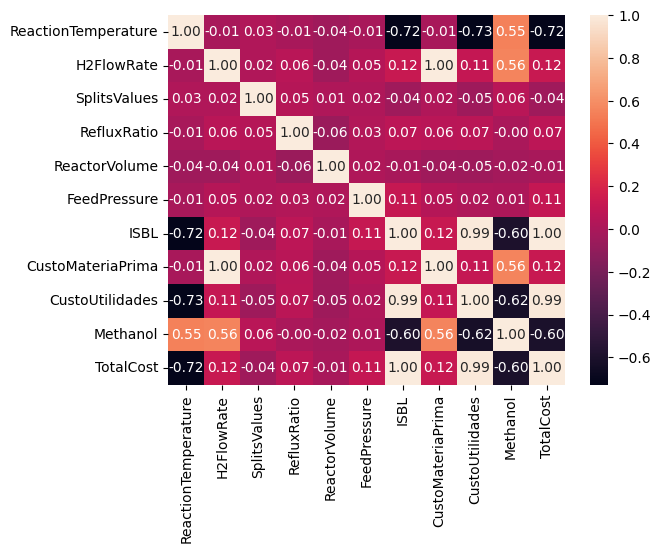

In [332]:
dfn=dft.drop(columns=['ISBL','CustoUtilidades','CustoMateriaPrima'])
sns.heatmap(dft.corr(),annot=True,annot_kws={'size':'10'},fmt='.2f')


ISBL e CustoUtilidades são Targets redundantes, portanto TAC, Methanol e CustoMatériaPrima serão trabalhados

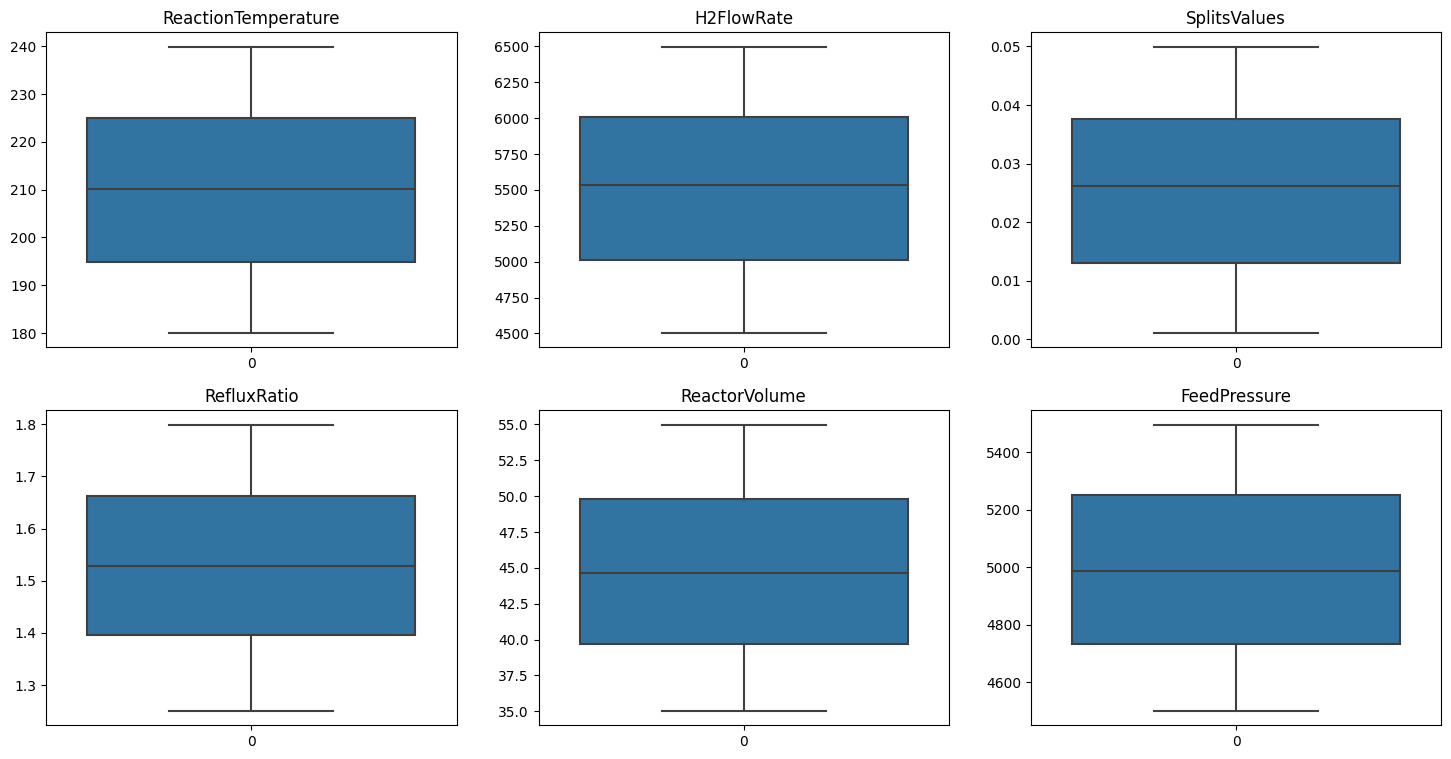

In [331]:
fig,axes=plt.subplots(2,3,figsize=(18,9))
axesf=axes.flatten()
for i, columns in enumerate(dfn[features].columns.to_list()):
    ax=axesf[i]
    ax.set_title(columns)
    sns.boxplot(dfn[columns],ax=ax)



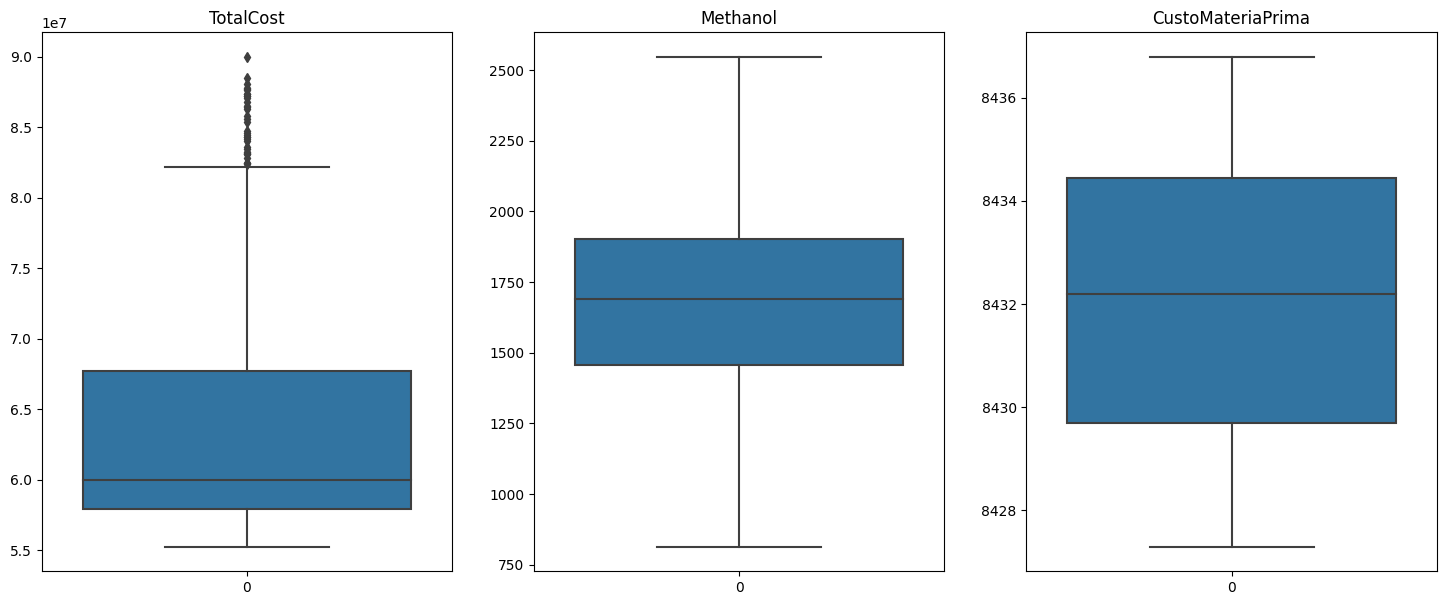

In [337]:
fig,axes=plt.subplots(1,3,figsize=(18,7))
axesf=axes.flatten()
for i, columns in enumerate(dft[target].columns.to_list()):
    ax=axesf[i]
    ax.set_title(columns)
    sns.boxplot(dft[columns],ax=ax)

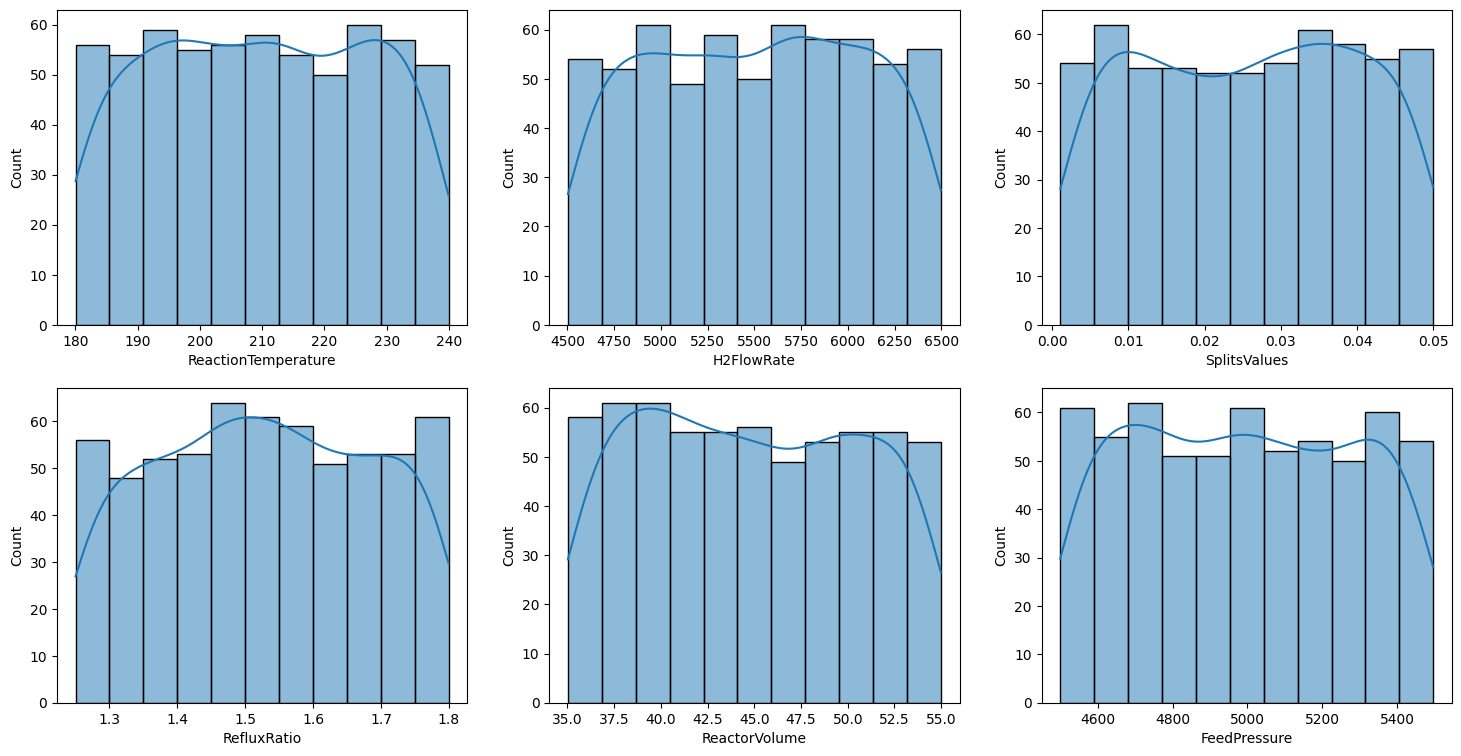

In [401]:
fig,axes=plt.subplots(2,3,figsize=(18,9))
axesf=axes.flatten()
for i, columns in enumerate(dfn[features].columns.to_list()):
    ax=axesf[i]
    sns.histplot(dfn[columns],ax=ax,kde=True)
    

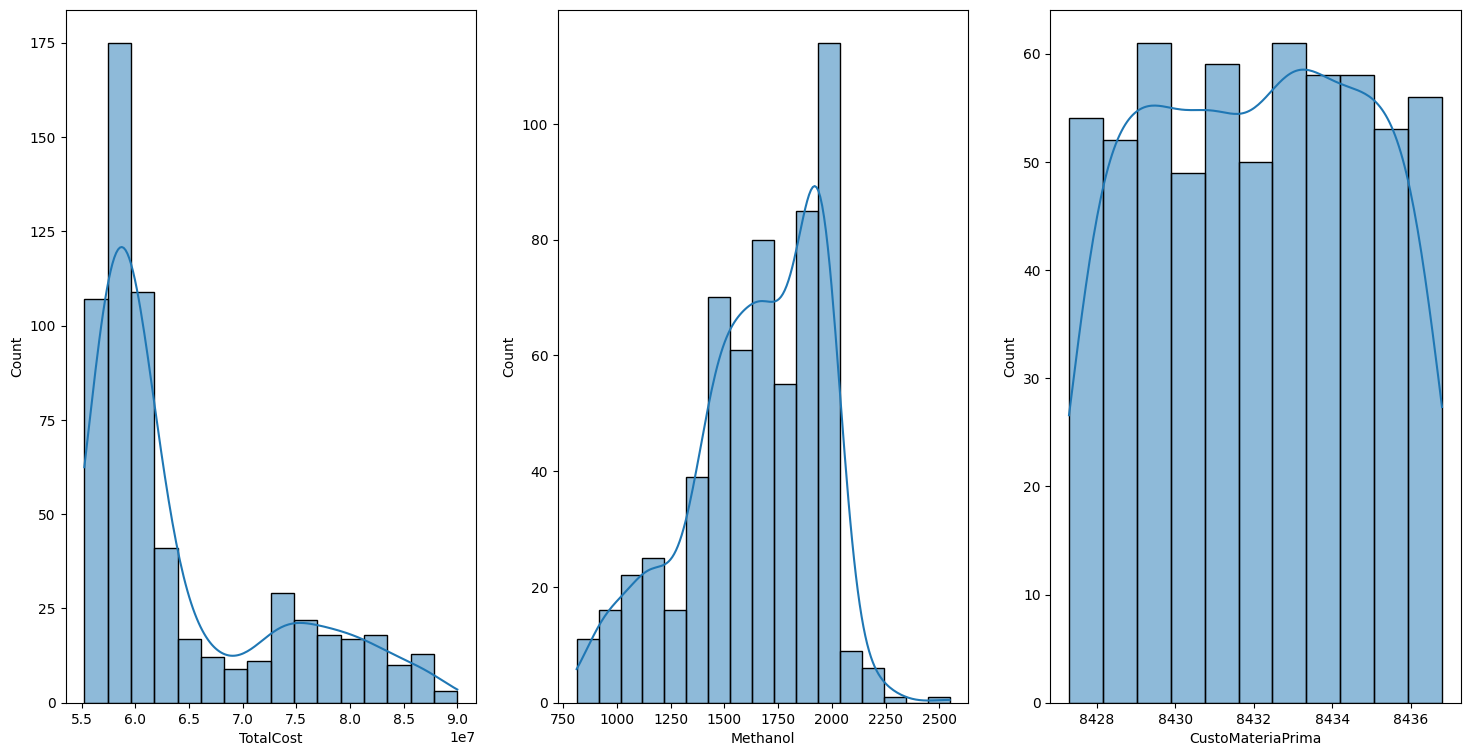

In [400]:
fig1,axes1=plt.subplots(1,3,figsize=(18,9))
axesf1=axes1.flatten()
for i, columns in enumerate(dft[target].columns.to_list()):
    ax1=axesf1[i]
    sns.histplot(dft[columns],ax=ax1,kde=True)


TAC e Methanol com OUTLIERS, tratamento de dados a serem aplicados:

In [408]:
df_trans=dft
pp=ColumnTransformer([('StandardScaler',StandardScaler(),features+['CustoMateriaPrima']),('QuantileTransformer',QuantileTransformer(),['TotalCost','Methanol'])],verbose=True)


(pp.fit_transform(df_trans))

pp.get_feature_names_out()

[ColumnTransformer]  (1 of 2) Processing StandardScaler, total=   0.0s
[ColumnTransformer]  (2 of 2) Processing QuantileTransformer, total=   0.0s


c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (611). n_quantiles is set to n_samples.
  warnings.warn(


array(['StandardScaler__ReactionTemperature',
       'StandardScaler__H2FlowRate', 'StandardScaler__SplitsValues',
       'StandardScaler__RefluxRatio', 'StandardScaler__ReactorVolume',
       'StandardScaler__FeedPressure',
       'StandardScaler__CustoMateriaPrima',
       'QuantileTransformer__TotalCost', 'QuantileTransformer__Methanol'],
      dtype=object)